## Imports

In [6]:
import os
import matplotlib.pyplot as plt
import torch
import numpy as np

from mmaction.datasets import MixupBlending
from dataset import MultiModalDataset

## Function for saving videos

In [7]:
"""Function to save videos in ./outputs.

Args:
    video_tensor (Tensor): The video tensor in BNCTHW format.
    index (int): The video index in the batch. Default: 0.
"""
def output_video(video_tensor, index=0):
    os.makedirs('output', exist_ok=True)
    for i, np_image in enumerate(video_tensor[index].squeeze().permute(1,2,3,0)):
        print(np_image.shape)
        img_array = np.array(np_image.numpy())
        plt.imshow(img_array)
        plt.axis('off')  # Turn off axis labels and ticks

        # Save the image using plt.savefig()
        output_path = f"output/{i}.jpg"
        plt.savefig(output_path, bbox_inches='tight', pad_inches=0, dpi=300)

## Loading batches

In [8]:
dataset = MultiModalDataset(ann_file='../../data/autsl/train_annotations.txt',
                            root_dir='../../data/autsl/rawframes',
                            clip_len=32,
                            resolution=512,
                            modalities=('rgb'),
                            test_mode=False,
                            frame_interval=1,
                            input_resolution=512,
                            num_clips=1
                            )

In [9]:
train_loader = torch.utils.data.DataLoader(dataset=dataset,
                                                batch_size=4,
                                                shuffle=True,
                                                num_workers=4,
                                                pin_memory=True)

In [10]:
iter_ = iter(train_loader)

In [11]:
result = next(iter_)
imgs = result['rgb'].unsqueeze(dim=1)
labels = result['label'].unsqueeze(dim=1)
imgs.shape

torch.Size([4, 1, 3, 32, 512, 512])

## Mixup

In [ ]:
mixup = MixupBlending(num_classes=226, alpha=0.2)

In [ ]:
mixed_imgs, mixed_label = mixup.do_blending(imgs['rgb'], imgs['label'])

In [ ]:
mixed_imgs.shape

In [ ]:
mixed_imgs.squeeze().shape

## Scrambmix

In [11]:
from mmaction.datasets import Scrambmix

In [12]:
scrambmix = Scrambmix(num_classes=226, num_frames = 32, alpha=5)

In [14]:
mixed_imgs, mixed_label = scrambmix.do_blending(imgs, labels)

0.3333333333333333

In [15]:
mixed_imgs.shape

torch.Size([4, 1, 3, 32, 512, 512])

In [16]:
labels

tensor([[103],
        [ 37],
        [ 78],
        [ 79]])

In [17]:
mixed_label

tensor([[103.0000],
        [ 37.0000],
        [ 78.3333],
        [ 78.6667]])

In [20]:
mixed_imgs.shape

torch.Size([4, 1, 3, 32, 512, 512])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])
torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 512, 3])


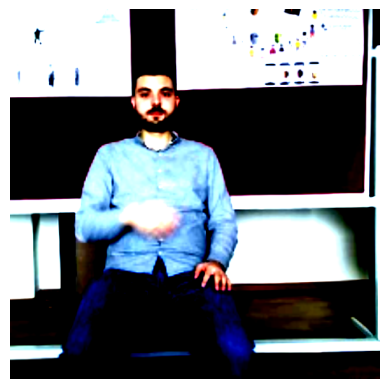

In [24]:
output_video(imgs, 2)